모듈 세팅

In [15]:
%pip install ipywidgets
#%pip uninstall tensorflow
%pip install tensorflow
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv
%pip install torch


import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv

#pytorch를 불러오고, nmist -> fashionmnist로 변환하였음
from pytorchcv import load_fashionmnist, train, plot_results, plot_convolution, display_dataset
train_loader, test_loader = load_fashionmnist(batch_size=64)


#ipywidgets의 경우 ctrl + shift + p > 터미널 열기 -> 를 통해 직접 인스톨했습니다.
#tensorflow 모듈이 불러오지 않을경우 해당 모듈을 삭제하고 tensorflow만 재설치하는 작업을 진행했습니다.
#만약 [NameError: name 'transforms' is not defined] 오류 혹은 모듈 import 오류가 발생할경우 상단의
#모두 실행 옆 재시작 기능으로 커널을 재 시작하여주십시오.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
--2024-04-19 13:52:47--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.2’

pytorchcv.py.2      100%[===================>]   6.39K  --.-KB/s    in 0s      

2024-04-19 13:52:47 (17.7 MB/s) - ‘pytorchcv.py.2’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use up

기본 mnist를 사용한 데이터, 레이블 셋 호출 테스트

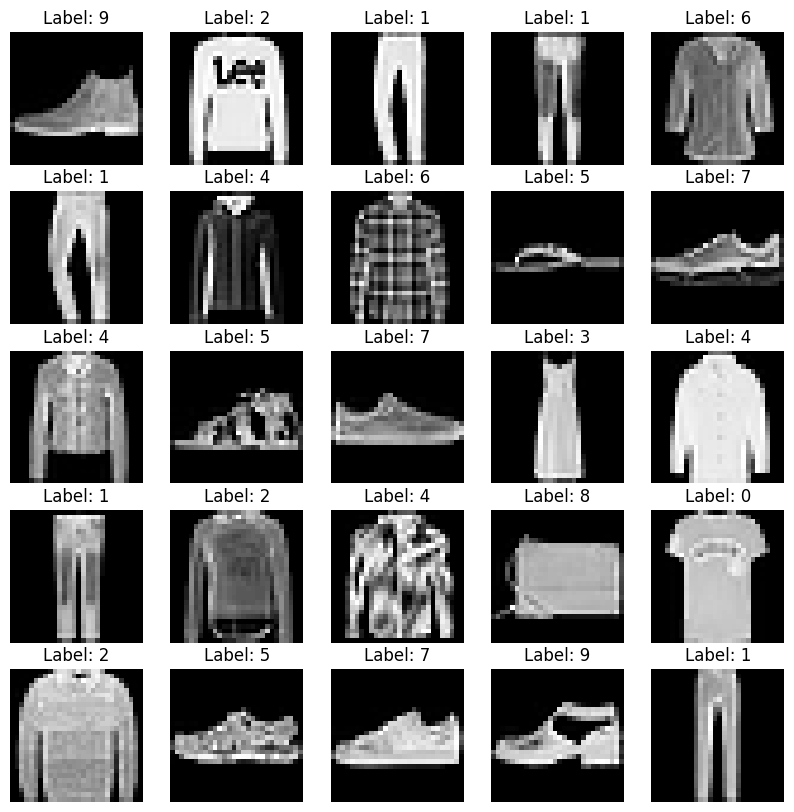

In [16]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

# 데이터, 레이블 호출
with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    image_data = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    label_data = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

# 시각화
num_rows = 5
num_cols = 5
plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.title(f'Label: {label_data[i]}')
    plt.axis('off')
plt.show()


데이터 분석:

Fashionmnist를 사용한 데이터셋 사용

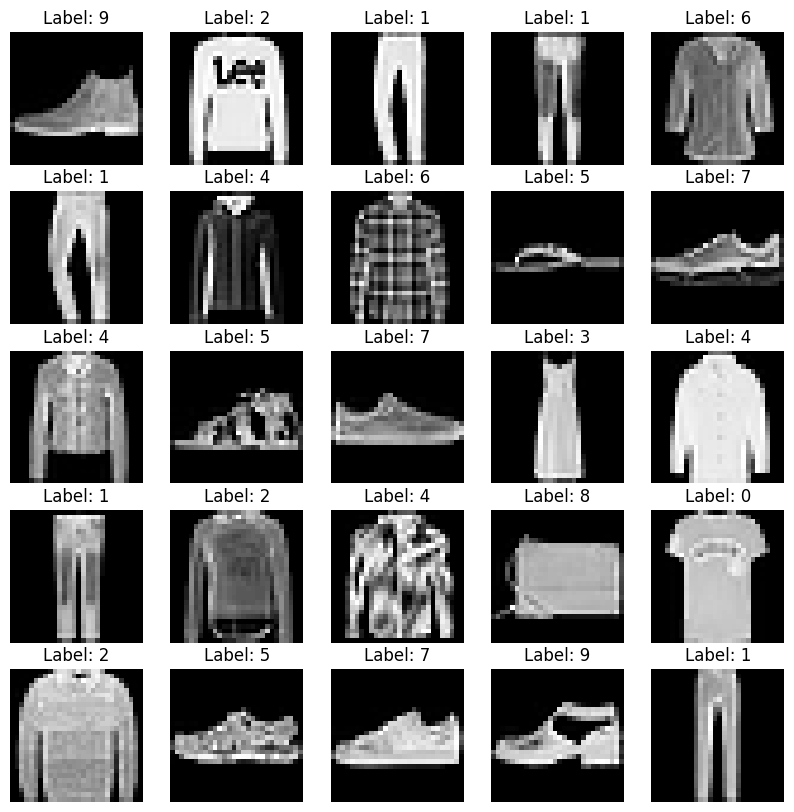

In [17]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import FashionMNIST

# FashionMNIST로 호출
test_dataset = FashionMNIST(root='./data', train=False, download=True)

# 이미지 데이터와 레이블 로드
image_data = test_dataset.data.numpy()
label_data = np.array(test_dataset.targets)

# 시각화할 이미지 수 설정 5*5
num_rows = 5
num_cols = 5

# 이미지 및 레이블 시각화
plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.title(f'Label: {label_data[i]}')
    plt.axis('off')
plt.show()


MNIST와 FashionMnist를 사용해본 결과 탐색과 분류결과는 둘다 잘 나오지만 확연한 차이를 구분할수 없음

모델 구축 및 훈련:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#cnn모델 생성
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            #컨볼루션 레이어
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #풀링 레이어
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(16 * 14 * 14, 10)  
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  
        x = self.fc(x)
        return x

#fashion mnist 모델 호출
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 모델 실행
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#학습
num_epochs = 5 #에폭은 5로 설정
for epoch in range(num_epochs):
    #각 데이터 초기화
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Training finished!')


Epoch [1/5], Loss: 0.4340, Accuracy: 84.80%
Epoch [2/5], Loss: 0.3126, Accuracy: 88.99%
Epoch [3/5], Loss: 0.2833, Accuracy: 90.11%
Epoch [4/5], Loss: 0.2623, Accuracy: 90.82%
Epoch [5/5], Loss: 0.2484, Accuracy: 91.20%
Training finished!


Result : 

5번의 epoch동안 학습 결과 확인

loss: 에폭수에 따라 손실이 감소하는 것을 확인. 훈련을 반복할수록 정확도(acc)가 상승하는 모습.

정확도 향상: 에폭이 증가함에 따라 정확도가 향상되는 것을 확인할 수 있음

//////////////////////////////////

모델 평가 및 결과 분석:

학습

In [19]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

분석

Epoch 1/5: Train Loss: 0.0047, Train Acc: 90.01%, Test Loss: 0.0050, Test Acc: 88.85%
Epoch 2/5: Train Loss: 0.0041, Train Acc: 90.87%, Test Loss: 0.0049, Test Acc: 89.11%
Epoch 3/5: Train Loss: 0.0039, Train Acc: 91.31%, Test Loss: 0.0049, Test Acc: 89.24%
Epoch 4/5: Train Loss: 0.0037, Train Acc: 91.68%, Test Loss: 0.0048, Test Acc: 89.39%
Epoch 5/5: Train Loss: 0.0036, Train Acc: 91.99%, Test Loss: 0.0048, Test Acc: 89.47%


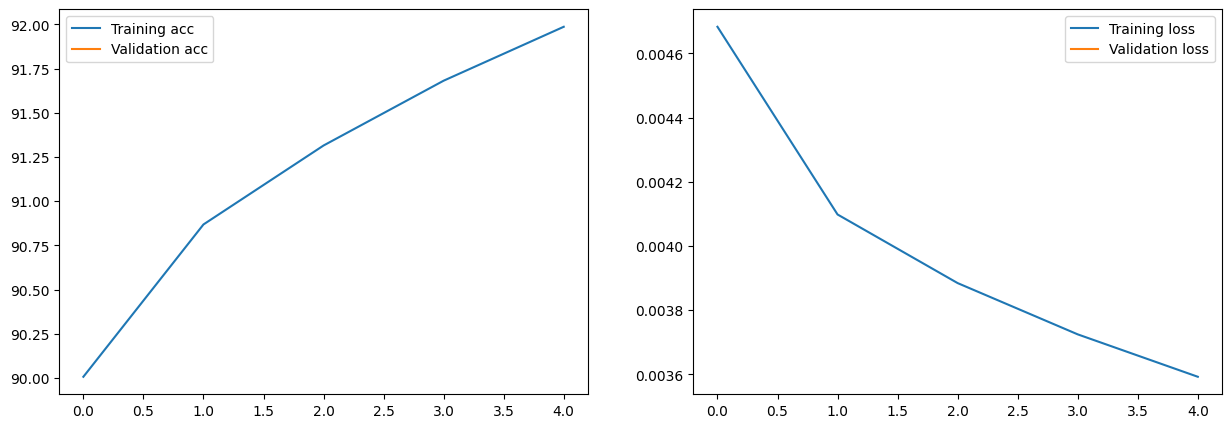

In [20]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(model, train_loader, test_loader, epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

Result : 

테스트 데이터를 통해 학습시키고 정확도 평가

마지막 5번째 epoch에서 정확도는 약 91.99%. 이는 테스트 데이터셋에서 모델이 올바르게 분류한 샘플의 비율을 나타냄

train loss는 학습을 진행할수록 손실이 감소
train acc는 학습을 진행할수록 정확도가 증가

Test Loss는 학습할수록 데이터셋 손실이 증가하지만 0.0049에서 큰 편차를 가지지않음
Test Acc는 학습을 거듭하면서 데이터셋에대한 정확도 즉, 올바르게 분류한 샘플의 비율을 나타낸다.
좌측 그래프를 보면 정확도(acc)는 우상향을 그리며 점차 정확해 지지만 어느 시점에선 정확성이 둔화됨
우측 그래프 손실(loss)는 학습할수록 손실이 줄어들며 정확성을 늘리지만 이 또한 어느 순간엔 둔화됨

////////////////////////////////////////////////////////////////////////
TEST 

Epochs를 50으로 늘려 학습횟수를 늘리는 실험

아래 테스트는 많은 학습 시간을 요구하니 실행에 주의해주시기 바랍니다

Epoch 1/50: Train Loss: 0.0035, Train Acc: 92.19%, Test Loss: 0.0048, Test Acc: 89.40%
Epoch 2/50: Train Loss: 0.0034, Train Acc: 92.48%, Test Loss: 0.0048, Test Acc: 89.47%
Epoch 3/50: Train Loss: 0.0033, Train Acc: 92.66%, Test Loss: 0.0048, Test Acc: 89.55%
Epoch 4/50: Train Loss: 0.0032, Train Acc: 92.83%, Test Loss: 0.0048, Test Acc: 89.56%
Epoch 5/50: Train Loss: 0.0031, Train Acc: 93.04%, Test Loss: 0.0048, Test Acc: 89.63%
Epoch 6/50: Train Loss: 0.0031, Train Acc: 93.19%, Test Loss: 0.0049, Test Acc: 89.66%
Epoch 7/50: Train Loss: 0.0030, Train Acc: 93.34%, Test Loss: 0.0049, Test Acc: 89.66%
Epoch 8/50: Train Loss: 0.0029, Train Acc: 93.49%, Test Loss: 0.0049, Test Acc: 89.65%
Epoch 9/50: Train Loss: 0.0029, Train Acc: 93.65%, Test Loss: 0.0049, Test Acc: 89.66%
Epoch 10/50: Train Loss: 0.0028, Train Acc: 93.75%, Test Loss: 0.0050, Test Acc: 89.71%
Epoch 11/50: Train Loss: 0.0028, Train Acc: 93.82%, Test Loss: 0.0050, Test Acc: 89.71%
Epoch 12/50: Train Loss: 0.0027, Train Ac

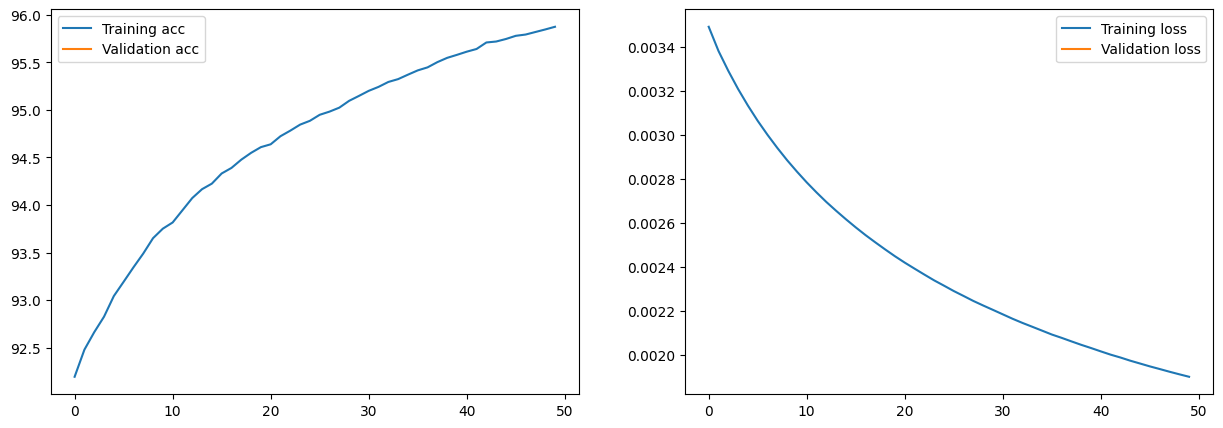

In [21]:
hist = train(model, train_loader, test_loader, epochs=50)

if hist is None:
     print("Training did not return any history.")
else: 
    plot_results(hist) 

50회를 테스트했을때 이전과는 다르게 완만함을 보이며, 급격하게 꺾이는 지점도 없으며 편차도 많이 줄어듬

단. 테스트 횟수, 환경, 데이터 분류에 따라 결과는 충분히 다를수 있음 (이전 학습 횟수를 40회로 늘렸을때에 주식 그래프처럼 뾰족한 부분이 많이 보였음)